In [1]:
import ase
import ase.io
from ase.io import xsf
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [2]:
dataframe_df2 = pd.read_pickle("pickle_files/DataFrame_df2.pkl")
dataframe_df2.head()

,uuid,structure,cell,volume,relevant_dimension_of_highest_dimensionality_substructure,binding_energy_per_substructure,binding_energy,label,number_of_atoms_in_bulk,number_of_highest_dimensionality_substructures_in_bulk,sub_structure_spg,sub_structure_dim,energy_bulk,sub_structure_formula,PMG Structure from ASE Atoms
0,dec2d070-d2ad-41f3-b742-786368ade33a,"(Atom('Cd', [-0.0, -0.0, 29.0441583], index=0)...","[[2.1044124705, 1.2149831063, 34.279850741], [...",525.885600,15.340954,-0.165000,10.755509,EE,15,5,"[C2/m (12), C2/m (12), C2/m (12), C2/m (12), C...","[2, 2, 2, 2, 2]",-17198.871453,"[CdI2, CdI2, CdI2, CdI2, CdI2]",[[-7.99325051e-18 -1.35384926e-17 2.90441583e...
1,51e630e8-d94f-421c-bd1e-3e2f298e740c,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('C...","[[3.35814166734363, 3.21879556184565e-14, -3.2...",52.188194,9.766268,-0.149888,15.347484,EE,3,1,[P-3m1 (164)],[2],-5361.474444,[Cl2Fe],"[[0. 0. 0.] Fe, [7.65128701e-17 2.06980071e+00..."
2,527e7b32-d211-4743-9631-120122819190,"(Atom('Er', [2.1386, 4.301805, 3.209025], inde...","[[2.14789490163679, -12.5878501270869, 0.0], [...",232.520056,18.471785,-0.454048,24.580650,EE,8,1,[P2_1/m (11)],[2],-26090.090963,[Er2Te6],"[[2.1386 4.301805 3.209025] Er, [ 2.1386 -..."
3,37bf14b1-6529-436c-a519-e1ad9b208784,"(Atom('Ba', [0.0, 0.0, 9.5697], index=0), Atom...","[[-2.0745739339, 2.0745739339, 7.4278571834], ...",127.873741,17.215428,-0.747937,43.445746,PE,3,1,[C2/m (12)],[2],-2866.173187,[Ba2Hg],[[-1.10578213e-16 1.10578213e-16 9.56970000e...
4,e7a9cec3-f11a-4d16-a8c5-ebd758bb6592,"(Atom('Ba', [0.0, 2.414, 1.49473], index=0), A...","[[4.6829418165, 0.0, 0.0], [0.0, 4.6829418165,...",166.823529,21.929944,-0.532853,24.297979,EE,6,1,[P4/nmm (129)],[2],-3217.539658,[Ba2H2I2],"[[0. 2.414 1.49473] Ba, [2.414 0. ..."


In [3]:
dataframe_df2.columns

Index(['uuid', 'structure', 'cell', 'volume',
       'relevant_dimension_of_highest_dimensionality_substructure',
       'binding_energy_per_substructure', 'binding_energy', 'label',
       'number_of_atoms_in_bulk',
       'number_of_highest_dimensionality_substructures_in_bulk',
       'sub_structure_spg', 'sub_structure_dim', 'energy_bulk',
       'sub_structure_formula', 'PMG Structure from ASE Atoms'],
      dtype='object')

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.structure import (SiteStatsFingerprint, StructuralHeterogeneity,
                                            ChemicalOrdering, StructureComposition, MaximumPackingEfficiency)
from matminer.featurizers.conversions import DictToObject
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [7]:
df = pd.read_pickle("./pickle_files/features_MultipleFeaturizer.pkl")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.777778,64.0,0.130435,0.217391,0.652174,0.000000,1.0,0.209607,0.046579,EE
1,6.000000,10.432235,4.432235,8.954823,1.969882,0.101871,1.076403,0.847193,1.119514e-11,0.171207,...,73.333333,64.0,0.272727,0.454545,0.272727,0.000000,1.0,0.357395,0.079421,EE
2,9.052693,11.479272,2.426579,9.749345,0.864963,0.020033,1.032994,0.959935,2.631480e-02,0.125121,...,15.750000,152.0,0.129032,0.193548,0.483871,0.193548,0.0,0.168813,0.031652,EE
3,10.187778,12.638871,2.451093,11.821840,1.089375,0.050764,1.038073,0.923854,4.593043e-02,0.102799,...,28.000000,229.0,0.200000,0.000000,0.333333,0.466667,0.0,0.265103,0.058912,PE
4,9.198422,14.426225,5.227803,11.335849,2.060251,0.087363,1.131045,0.914155,9.864448e-02,0.120736,...,65.555556,64.0,0.250000,0.250000,0.500000,0.000000,1.0,0.543070,0.104828,EE


In [8]:
features_with_small_contribution = [0, 1, 2, 3, 4, 5, 6,7, 8, 9,10,11,12,13, 128, 129,130,131,132,133,134,135,
                         136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,
                         155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,
                         174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,
                         193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,
                         212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,
                         231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,
                         250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,
                         269,270,271,272]

In [9]:
df = df.drop(features_with_small_contribution, axis = 1)
df.head()

,14,15,16,17,18,19,20,21,22,23,...,119,120,121,122,123,124,125,126,127,label
0,NaN,NaN,NaN,0.392697,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE
1,0.353008,0.080997,0.067582,0.376482,3.618051,9.000000,5.381949,5.412034,2.391977,15.678221,...,2.110663,1.262164,1.26922,0.560962,66.330933,165.000000,98.669067,99.220622,43.852919,EE
2,0.500257,0.185244,0.066168,0.530390,2.526145,15.672277,13.146132,7.532116,5.001544,8.683625,...,0.000000,0.000000,0.00000,0.000000,6.631132,41.139728,34.508596,19.771803,13.129053,EE
3,0.225317,0.059013,0.052994,0.531858,9.055929,21.098280,12.042350,13.070046,5.352156,23.394484,...,0.000000,0.000000,0.00000,0.000000,23.771815,55.382985,31.611170,34.308871,14.049409,PE
4,0.416765,0.181752,0.128570,0.503722,12.897617,43.880729,30.983112,27.614702,10.844018,40.347793,...,0.000000,0.000000,0.00000,0.000000,57.948223,107.335599,49.387376,89.654894,21.137781,EE


In [10]:
df = df.dropna()

In [11]:
df.head()

,14,15,16,17,18,19,20,21,22,23,...,119,120,121,122,123,124,125,126,127,label
1,0.353008,0.080997,0.067582,0.376482,3.618051,9.000000,5.381949,5.412034,2.391977,15.678221,...,2.110663,1.262164,1.26922,0.560962,66.330933,165.000000,98.669067,99.220622,43.852919,EE
2,0.500257,0.185244,0.066168,0.530390,2.526145,15.672277,13.146132,7.532116,5.001544,8.683625,...,0.000000,0.000000,0.00000,0.000000,6.631132,41.139728,34.508596,19.771803,13.129053,EE
3,0.225317,0.059013,0.052994,0.531858,9.055929,21.098280,12.042350,13.070046,5.352156,23.394484,...,0.000000,0.000000,0.00000,0.000000,23.771815,55.382985,31.611170,34.308871,14.049409,PE
4,0.416765,0.181752,0.128570,0.503722,12.897617,43.880729,30.983112,27.614702,10.844018,40.347793,...,0.000000,0.000000,0.00000,0.000000,57.948223,107.335599,49.387376,89.654894,21.137781,EE
5,0.476906,0.206932,0.109132,0.204110,19.080017,74.209136,55.129119,29.244639,12.846999,0.989455,...,0.000000,0.000000,0.00000,0.000000,0.000000,213.000000,213.000000,81.135835,56.513213,PE


In [12]:
df_removedNAS_label = df.drop('label', axis = 1)

In [13]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaler.fit(df_removedNAS_label)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
scaled_data = scaler.transform(df_removedNAS_label)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)

In [19]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
x_pca = pca.transform(scaled_data)

In [21]:
print(scaled_data.shape)
print(x_pca.shape)

(2213, 114)
(2213, 2)


In [25]:
df['label'].replace(to_replace='PE', value='EE', inplace=True)
df['label'].replace(to_replace='EE', value=1, inplace=True)
df['label'].replace(to_replace='HBE', value=0, inplace=True)

In [26]:
df['label']

1       1
2       1
3       1
4       1
5       1
       ..
2387    0
2388    0
2389    1
2390    1
2391    1
Name: label, Length: 2213, dtype: int64

Text(0, 0.5, 'Second Principal Component')

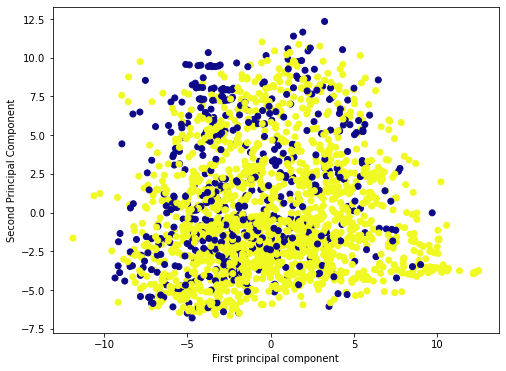

In [28]:
    plt.figure(figsize=(8,6))
    plt.scatter(x_pca[:,0],x_pca[:,1],c=df['label'],cmap='plasma')
#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(i, rotation=270)
    plt.xlabel('First principal component')
    plt.ylabel('Second Principal Component')
    #plt.savefig('generated_figures/PCA-ICSD-{}.jpg'.format(i),bbox_inches='tight',dpi=600)

***TSNE***

In [45]:
X = df_removedNAS_label.values

In [46]:
from sklearn.manifold import TSNE

In [47]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [48]:
X_embedded.shape

(2213, 2)

Text(0, 0.5, 'Second Principal Component')

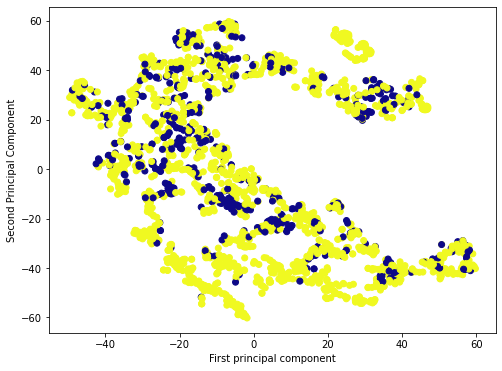

In [49]:
    plt.figure(figsize=(8,6))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=df['label'],cmap='plasma')
#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(i, rotation=270)
    plt.xlabel('First principal component')
    plt.ylabel('Second Principal Component')
    #plt.savefig('generated_figures/TSNE-QMOF-{}.jpg'.format(i),bbox_inches='tight',dpi=600)